(9610.77, 201.48)
(array([ 52., 126.]), 10773.73)
(10402.33, 892.04)


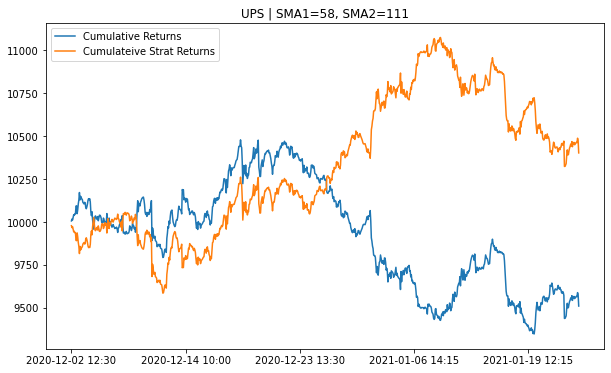

In [3]:
import os, requests, json, dateutil.parser, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brute
from datetime import datetime
from dotenv import load_dotenv

load_dotenv(verbose=True)
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

class AlpacaSMABacktester(object):
    
    def __init__(self, symbol, timeframe, SMA1, SMA2, start, end, bars=1000, amount=10000):
        
        """
        Class for the vectorized backtesting of SMA-based trading strategies.

        Attributes
        ==========
        timeframe: str
            One of minute, 1Min, 5Min, 15Min, day or 1D.
            minute is an alias of 1Min. Similarly, day is of 1D.
        symbol: str
            RIC symbol with which to work with
        SMA1: int
            time window in days for shorter SMA
        SMA2: int
            time window in days for longer SMA
        start: str
            start date for data retrieval
        end: str
            end date for data retrieval
        capital: float
            amount of starting capital being traded
        """
        
        self.timeframe = timeframe
        self.symbol = symbol
        self.SMA1 = SMA1
        self.SMA2 = SMA2
        self.start = start
        self.end = end
        self.bars = bars
        self.amount = amount
        self.results = None
        self.get_data()

    def get_data(self):
        
        '''
        Retrieves and prepares the data.
        '''
        
        # Alpaca Variables
        url = f"https://data.alpaca.markets/v1/bars/{self.timeframe}?symbols={self.symbol}&limit={self.bars}&start={self.start}&end={self.end}"
        header = {
            "APCA-API-KEY-ID": alpaca_api_key,
            "APCA-API-SECRET-KEY": alpaca_secret_key
        }

        # Data Acquisition -> JSON formatting -> Dictionary
        req = requests.get(url, headers=header)
        info = json.loads(json.dumps(req.json(), indent=4))[self.symbol]

        # Creating the DataFrame
        dates = []
        close = []
        
        # Formatting time for daily bars
        if self.timeframe == "1D":
            for day in info:
                day['t'] = datetime.fromtimestamp(day['t']).strftime('%Y-%m-%d')
                dates.append(day['t'])
                close.append(day['c'])
        # Formatting time for minute bars
        else:
            for day in info:
                day['t'] = datetime.fromtimestamp(day['t']).strftime('%Y-%m-%d %H:%M')
                dates.append(day['t'])
                close.append(day['c'])
                
            #dates = pd.to_datetime(dates, format="%Y-%m-%d, %H:%M")
                
        raw = pd.DataFrame(data={self.symbol:close}, index=dates)
        #raw = raw.loc[self.start:self.end]
        raw.rename(columns={self.symbol: 'Price'}, inplace=True)
        raw['Return'] = np.log(raw / raw.shift(1))
        raw['SMA1'] = raw['Price'].rolling(self.SMA1).mean()
        raw['SMA2'] = raw['Price'].rolling(self.SMA2).mean()
        self.data = raw
        
    def run_strategy(self):
        """
         Backtests trading strategy
        """
        
        # DATA
        data = self.data.copy().dropna()
        
        # POSITION, 1 LONG, -1 SHORT
        data['Position'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)
        
        # SIGNAL TO ACTION, 1 for LONG ORDER, -1 SHORT ORDER
        data['Signal'] = data['Position'][data['Position'].diff() != 0]
        
        # RETURNS
        data['Strategy Returns'] = data['Position'].shift(1) * data['Return']
        data['Cumulative Returns'] = self.amount * data['Return'].cumsum().apply(np.exp)
        data['Cumulateive Strat Returns'] = self.amount * \
            data['Strategy Returns'].cumsum().apply(np.exp)
        data['Signal'].fillna(0, inplace=True)
        
        # Drop first row of NaN data
        data.dropna(inplace=True)
        
        # results returns data DF
        self.results = data
        
        # Gross / Actual Performance
        aperf = data['Cumulateive Strat Returns'].iloc[-1]
        
        # Out or Under perform?
        operf = aperf - data['Cumulative Returns'].iloc[-1]
        
        return round(aperf, 2), round(operf, 2)
        
    def plot_results(self):
        
        """
         Plot the results of cumulative hold returns and strategy returns
        """

        if self.results is None:
            print('No results to plot yet. Run a strategy.')
        
        title = '%s | SMA1=%d, SMA2=%d' % (self.symbol,
                                           self.SMA1, self.SMA2)
        self.results[['Cumulative Returns', 'Cumulateive Strat Returns']].plot(title=title,figsize=(10, 6))
        
    
    def set_parameters(self, SMA1=None, SMA2=None):
        """
         sets parameters of SMA strategy
        """

        if SMA1 is not None:
            self.SMA1 = SMA1
            self.data['SMA1'] = self.data['Price'].rolling(
                self.SMA1).mean()
        if SMA2 is not None:
            self.SMA2 = SMA2
            self.data['SMA2'] = self.data['Price'].rolling(self.SMA2).mean()
        
    def update_and_run(self, SMA):
        """
         Update the parameters of the strategy and run.
        """
        self.set_parameters(int(SMA[0]), int(SMA[1]))
        return -self.run_strategy()[0]
    
    def optimize_parameters(self, SMA1_range, SMA2_range):
        """
         Brute force optimizer of SciKit Learn and 
        """
        opt = brute(self.update_and_run, (SMA1_range, SMA2_range), finish=None)
        return opt, -self.update_and_run(opt)

if __name__ == '__main__':
    ups = AlpacaSMABacktester(symbol="UPS",
                        timeframe="15Min",
                        SMA1=20, SMA2=50,
                        start="2019-01-01",
                        end="2019-01-07")
    
    print(ups.run_strategy())
    print(ups.optimize_parameters((20, 60, 1), (100, 200, 1)))
    ups.set_parameters(SMA1=58, SMA2=111)
    print(ups.run_strategy())
    ups.plot_results()